In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

2024-06-10 15:20:34.253269: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 15:20:34.253401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 15:20:34.367787: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sunspot-data/sunspot_dataset.csv


In [3]:
# Take a look into the data
data=pd.read_csv("/kaggle/input/sunspot-data/sunspot_dataset.csv")
data.head()

,index,date,average_sunspots
0,0,31-01-1850,148.225807
1,1,28-02-1850,169.750000
2,2,31-03-1850,156.838710
3,3,30-04-1850,83.833333
4,4,31-05-1850,117.032258


In [4]:
data.tail()

,index,date,average_sunspots
2087,2087,31-12-2023,113.548387
2088,2088,31-01-2024,123.032258
2089,2089,29-02-2024,124.689655
2090,2090,31-03-2024,104.903226
2091,2091,30-04-2024,136.466667


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2092 entries, 0 to 2091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             2092 non-null   int64  
 1   date              2092 non-null   object 
 2   average_sunspots  2092 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 49.2+ KB


In [5]:
sunspots = data.iloc[:,-1]
sunspots.values

array([148.2258065, 169.75     , 156.8387097, ..., 124.6896552,
       104.9032258, 136.4666667])

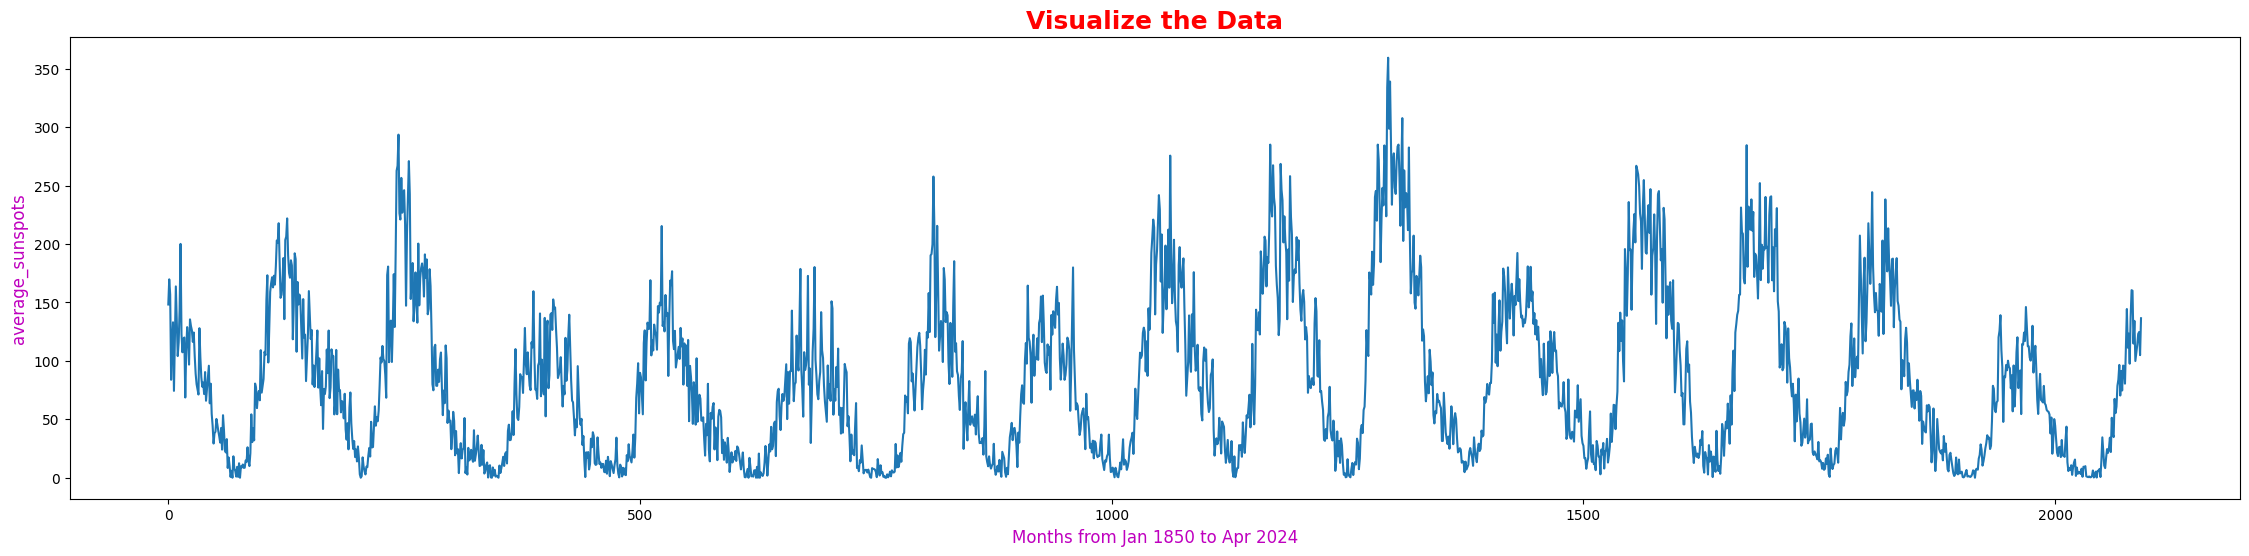

In [6]:
# Visualize the data
plt.figure(figsize=(28,6))
plt.plot(sunspots)
plt.ylabel(data.columns[-1], fontsize = 12, color = 'm')
plt.xlabel("Months from Jan 1850 to Apr 2024", fontsize = 12, color = 'm')
plt.title("Visualize the Data", fontsize = 18, color = 'r', weight = 'bold')
plt.show()

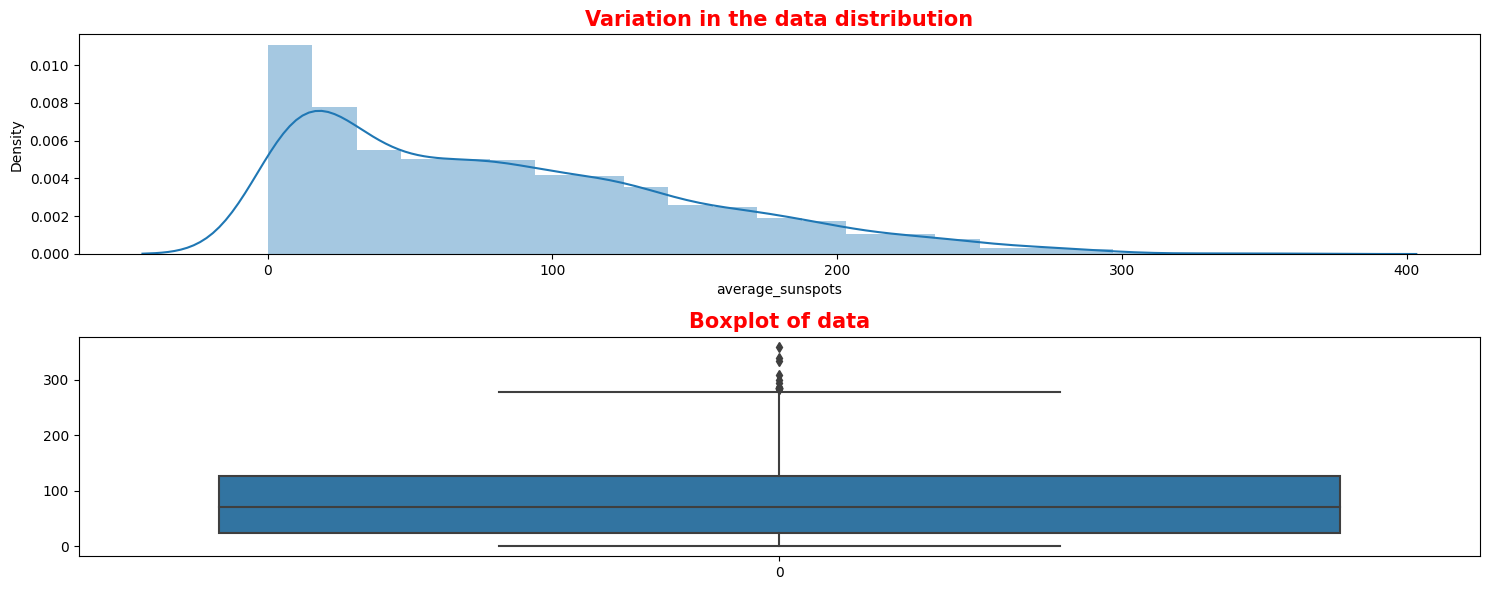

In [7]:
plt.figure(figsize = (15,6))
plt.subplot(2, 1, 1)
sns.distplot(sunspots)
plt.title("Variation in the data distribution", fontsize = 15, color = 'r', weight = 'bold')
plt.subplot(2, 1, 2)
sns.boxplot(sunspots)
plt.title("Boxplot of data", fontsize = 15, color = 'r', weight = 'bold')
plt.tight_layout()
plt.show()

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = series[:, np.newaxis]
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
# Forecast function
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
series = data['average_sunspots'].values
time = data['index'].values

# Splitting the data into train and test
split_time = int(len(series) * 0.9)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
print(f"There are {len(x_train)} training samples and {len(x_valid)} validation samples.")

# Parameters
delta = 1
window_size = 60
batch_size = 145
shuffle_buffer_size = 900
epochs = 100
train_epochs = epochs + 100
momentum_sgd = 0.9

There are 1882 training samples and 210 validation samples.


In [14]:
# Using the same steps to build the model but now with the GRU
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=132, kernel_size=4, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
  tf.keras.layers.GRU(256, return_sequences=True),
  tf.keras.layers.GRU(132, return_sequences=False),
  tf.keras.layers.Dense(80, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()

# Find the best learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20), verbose=0)

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=momentum_sgd)
model.compile(loss=tf.keras.losses.Huber(delta=float(delta)), optimizer=optimizer, metrics=["mae"])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 132)      │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 256)      │       299,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 132)            │       154,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │        10,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 466,081 (1.78 MB)

 Trainable params: 466,081 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(train_set, epochs=epochs, callbacks=[lr_schedule])

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 88.0762 - mae: 88.5759 - learning_rate: 1.0000e-08
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 59.9910 - mae: 60.4899 - learning_rate: 1.1220e-08
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 49.1636 - mae: 49.6617 - learning_rate: 1.2589e-08
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 44.6820 - mae: 45.1801 - learning_rate: 1.4125e-08
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 39.9308 - mae: 40.4280 - learning_rate: 1.5849e-08
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 36.6784 - mae: 37.1763 - learning_rate: 1.7783e-08
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 34.0878 - mae: 34.5855 - learning_rate: 1.9953e-08
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 32.0277 - mae: 32.5236 - learning_rate: 2.2387e-08
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 30.6727 - mae: 31.1708 - learning_rate: 2.5119e-08
E

In [16]:
lrs = 1e-8 * (10**(np.arange(epochs)/20))
lrs

array([1.00000000e-08, 1.12201845e-08, 1.25892541e-08, 1.41253754e-08,
       1.58489319e-08, 1.77827941e-08, 1.99526231e-08, 2.23872114e-08,
       2.51188643e-08, 2.81838293e-08, 3.16227766e-08, 3.54813389e-08,
       3.98107171e-08, 4.46683592e-08, 5.01187234e-08, 5.62341325e-08,
       6.30957344e-08, 7.07945784e-08, 7.94328235e-08, 8.91250938e-08,
       1.00000000e-07, 1.12201845e-07, 1.25892541e-07, 1.41253754e-07,
       1.58489319e-07, 1.77827941e-07, 1.99526231e-07, 2.23872114e-07,
       2.51188643e-07, 2.81838293e-07, 3.16227766e-07, 3.54813389e-07,
       3.98107171e-07, 4.46683592e-07, 5.01187234e-07, 5.62341325e-07,
       6.30957344e-07, 7.07945784e-07, 7.94328235e-07, 8.91250938e-07,
       1.00000000e-06, 1.12201845e-06, 1.25892541e-06, 1.41253754e-06,
       1.58489319e-06, 1.77827941e-06, 1.99526231e-06, 2.23872114e-06,
       2.51188643e-06, 2.81838293e-06, 3.16227766e-06, 3.54813389e-06,
       3.98107171e-06, 4.46683592e-06, 5.01187234e-06, 5.62341325e-06,
      

In [21]:
lrs = 1e-8 * (10**(np.arange(epochs)/20))
min_loss = min(history.history['loss'])
idx_min_loss = history.history['loss'].index(min_loss)
opt_lr = lrs[idx_min_loss]
print(f"Optimal Learning Rate {opt_lr}.")

Optimal Learning Rate 1.9952623149688787e-06.


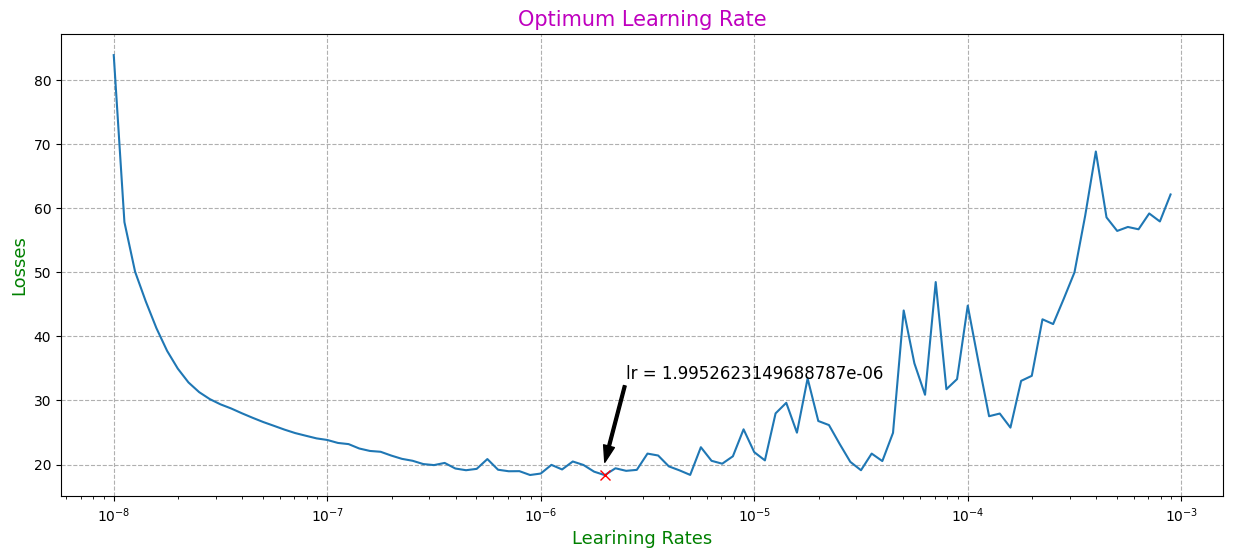

In [24]:
fig = plt.figure(figsize=(15, 6))
plt.semilogx(lrs, history.history["loss"])
plt.grid(True, ls="--")
plt.plot(opt_lr,min_loss, color = 'r', marker = 'x', markersize = 7)
plt.title(f"Optimum Learning Rate", color = 'm', fontsize = 15)
plt.ylabel("Losses", fontsize = 13, color = 'g')
plt.xlabel("Learining Rates", fontsize = 13, color = 'g')
plt.annotate(f"lr = {opt_lr}", (opt_lr,min_loss+2), (opt_lr+0.05e-5, min_loss+15), arrowprops = dict(facecolor ='k', width = 2, headwidth = 8), fontsize = 12)
plt.show()

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=132, kernel_size=4, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
    tf.keras.layers.GRU(256, return_sequences=True),
    tf.keras.layers.GRU(132, return_sequences=False),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=opt_lr, momentum=momentum_sgd)
model.compile(loss=tf.keras.losses.Huber(delta=float(delta)), optimizer=optimizer, metrics=["mae"])

In [26]:
history = model.fit(windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size), epochs=train_epochs)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 33.8163 - mae: 34.3129
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 22.8019 - mae: 23.2973
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 20.4831 - mae: 20.9783
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 20.5286 - mae: 21.0215
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 21.4354 - mae: 21.9288
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 18.8753 - mae: 19.3704
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 18.2638 - mae: 18.7570
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 19.5683 - mae: 20.0645
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 19.6063 - mae: 20.1003
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 18.2371 - mae: 18.7288
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 19.5702 - mae: 20.0655
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 18.5284 - mae: 19.0233
E

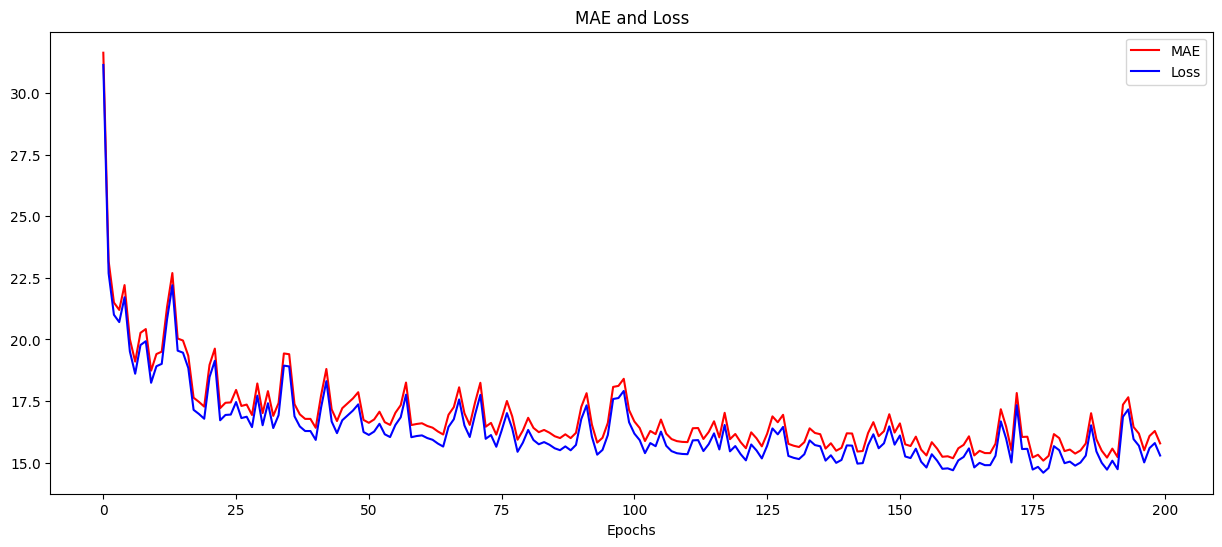

In [27]:
mae=history.history['mae']
loss=history.history['loss']

fig = plt.figure(figsize=(15, 6))
plt.plot(mae, 'r')
plt.plot(loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.legend(["MAE", "Loss"])

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


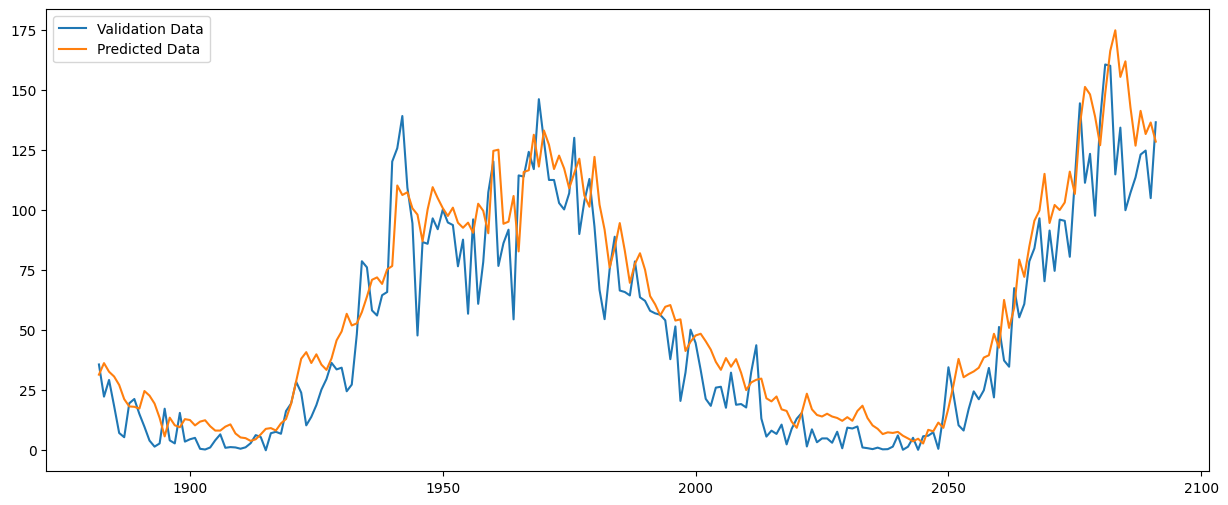

In [28]:
rnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, 0]

plt.figure(figsize=(15, 6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, rnn_forecast)
plt.title("")
plt.legend(["Validation Data", "Predicted Data"])
plt.show()

In [29]:
val_mae=tf.keras.metrics.mae(x_valid, rnn_forecast).numpy()
print(f"MAE on the validation data:- {val_mae}")

MAE on the validation data:- 13.147577285766602
